# Econometrics: Time Series
Notebook walks through key components of econometrics/financial time series.

This is important in building out quantitative trading strategies, backtesting etc.

Key concepts/terminology
1. Autoregression
    - Stationarity
    - 
2. Cointegration
3. OU Process

##### Packages

In [174]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)
from scipy.stats import skew, kurtosis
import pandas as pd

##### Functions

In [175]:
from statsmodels.tsa.stattools import adfuller
def adf_test(data):
    test_results = adfuller(data)
    print('ADF Statistic: ',test_results[0])
    print('P-Value: ',test_results[1])
    print('Critical Value: ',)
    for thres,adf_stat in test_results[4].items():
       print('\t%s: %.2f' % (thres,adf_stat))

In [265]:
def ar(c, phis, n_steps, std, burn_in=100):
    phis = np.asarray(phis)
    p = len(phis)

    n_total = n_steps + burn_in
    x = np.zeros(n_total)
    eps = np.random.normal(0, std, n_total)

    for t in range(p, n_total):
        x[t] = c + np.dot(phis, x[t-p:t][::-1]) + eps[t]

    return x[burn_in:]

In [266]:
def monte_carlo_output_analysis(n_simulations, paths_arrays):
    """
    Inputs:
    n_simulations: number of simulated paths
    paths_arrays: list/array of simulated paths

    Outputs:
    - Graph of Monte Carlo paths
    - Histogram of final results
    - Determine mean, std, kurtosis, skew and determine the spread 
    """
    final_values = []
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    
    # plot the different paths
    for i in range(n_simulations):
        ax[0].plot(paths_arrays[i])
        final_values.append(paths_arrays[i][-1])
    
    ax[0].set_title('Monte Carlo of AR(1)')
    ax[0].set_xlabel('Time Step')
    ax[0].set_ylabel('Value')

    ax[1].hist(final_values)
    ax[1].set_title('Distribution of Final Values')
    ax[1].set_xlabel('Final Value')
    ax[1].set_ylabel('Frequency')

    mean = round(np.mean(final_values),4)
    std = round(np.std(final_values),4)
    skew_value = round(skew(final_values),4)
    kurtosis_value = round(kurtosis(final_values),4)

    print("Mean:",mean)
    print("Std:", std)
    print("Skew:", skew_value)
    print("Kurtosis:", kurtosis_value)

    plt.tight_layout()
    plt.show()

    return final_values

## 1. Autoregression
Autoregression is a stochastic process which models the output of a random variable time series is dependent on previous values and a stochastic term with error. Resulting in a stochastic difference equation.

AR(P): Denotes the number of periods that are used to impact the current price. The strength of the parameters over the previous time steps denotes different outcomes.

- Param = 1: The process is a non stationary, martingale where the next value is simply dependent on the last value plus some new noise.
- Param = 0<param<1: The process has momentum and has persistence but is ultimately mean reverting
- Param = -1<param<0: Mean reversion - the process oscilates so if we have positive value previous then we are likely to have negative the next period plus noise

### AR(0)
AR(0) has no parameters so it is simply random noise.

For the remainder of the notebook, it is assumed that it is a standard normal distribution.

$
X_t = \varepsilon_t, \qquad \varepsilon_t \sim \text{N}(0,1)
$

Text(0, 0.5, 'Value')

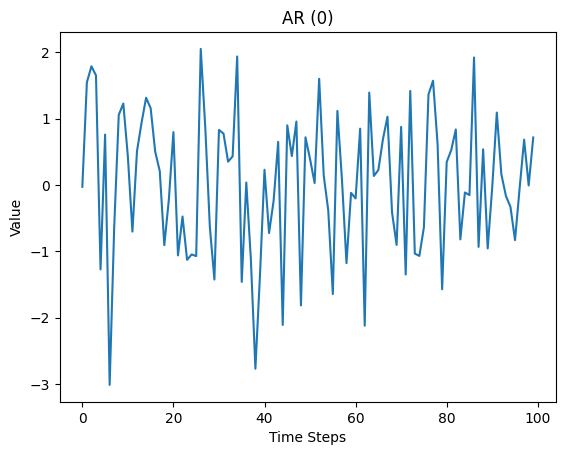

In [270]:
error = ar(0,[],100,1)
plt.plot(error)
plt.title('AR (0)')
plt.xlabel('Time Steps')
plt.ylabel('Value')

#### Stationarity
Stationarity is a fundamental component of time series analysis. If a series is stationary it assumes that the values in the series are pulled from a constant coefficient (mean and vol) distribution so data is going to fall around the mean and not deviate away.

In the above example a standard normal is used to generate the AR(0)

In [271]:
# test the adf test on the AR(0)
adf_test(error)

ADF Statistic:  -10.03152544265626
P-Value:  1.5803547736216588e-17
Critical Value: 
	1%: -3.50
	5%: -2.89
	10%: -2.58


As AR(0) data only pulls from the random error which is a standard normal distribution the data must be stationary.

### AR(1)

An AR(1) process includes a single parameter that controls the strength of dependence on the most recent past value.

As the parameter $\phi$ moves from 0 to 1, the process transitions from having almost no dependence on the previous value to exhibiting strong persistence. When $\phi = 1$, the process becomes a martingale (a random walk).

The following section explores how different values of $\phi$ affect the term $\phi X_{t-1}$ and, consequently, the dynamics of the process.


#### AR(1) $\phi$ = 1

Text(0, 0.5, 'Values')

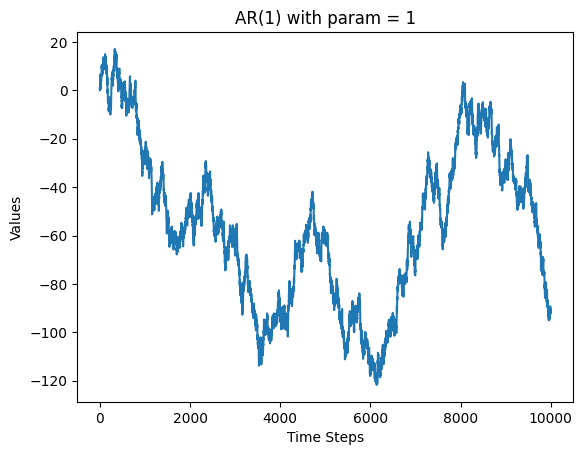

In [273]:
# using the function defined in 'functions' generate a simple AR(1) path
non_stationary_ar_1 = ar(0,[1],10000,1,0)
plt.plot(non_stationary_ar_1)
plt.title('AR(1) with param = 1')
plt.xlabel('Time Steps')
plt.ylabel('Values')

In [181]:
adf_test(non_stationary_ar_1)

ADF Statistic:  -0.9484774061692511
P-Value:  0.7715894279613993
Critical Value: 
	1%: -3.43
	5%: -2.86
	10%: -2.57


AR(1) is meant to replicate log prices, with a $\phi$ = 1 it is a martingale (random walk) where there is significant swings in prices and returning to a mean is not noramlly distributed.

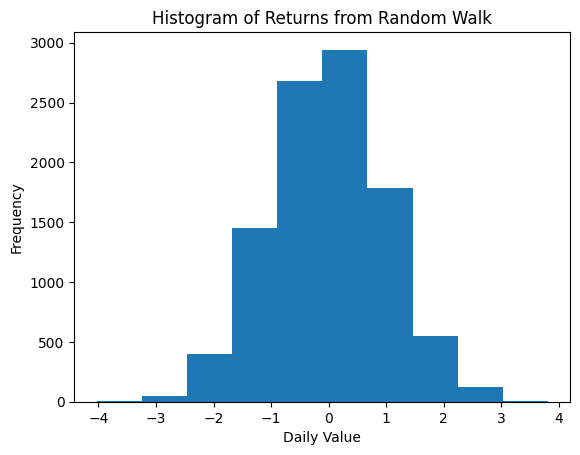

In [274]:
# look at the differences in daily prices to look at returns
non_stationary_ar_1_series = pd.Series(non_stationary_ar_1)
non_stationary_ar_1_series_returns = non_stationary_ar_1_series.diff()
plt.hist(non_stationary_ar_1_series_returns)
plt.title('Histogram of Returns from Random Walk')
plt.xlabel('Daily Value')
plt.ylabel('Frequency')
plt.show()

The daily returns have a normal distribution which is assumed when modeling real log prices (however fatter tails are a more accurate depiction of prices). These price returns exist due to the daily movement is dependent on the standard normal noise.

#### AR(1) $\phi$ = 0.8

Text(0, 0.5, 'Values')

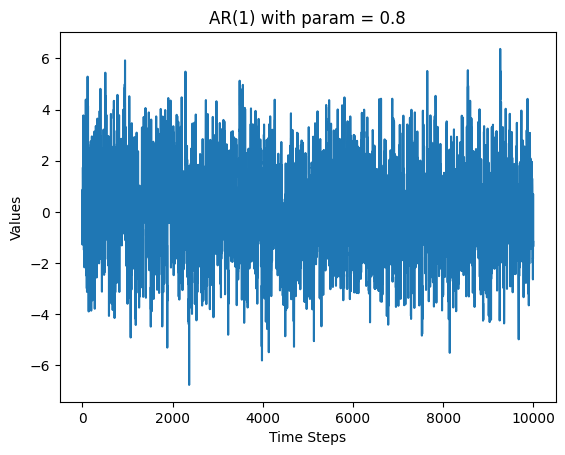

In [275]:
# using the funciton defined in 'funcitons' generate a simple AR(1) path
stationary_momentum_ar_1 = ar(0,[0.8],10000,1,0)
plt.plot(stationary_momentum_ar_1) # using a param of 0.8
plt.title('AR(1) with param = 0.8')
plt.xlabel('Time Steps')
plt.ylabel('Values')

There is a clear difference when the parameter is less than 1 there is a reverting force back to the mean which in the base case is 0.

In [276]:
adf_test(stationary_momentum_ar_1)

ADF Statistic:  -32.76777895101567
P-Value:  0.0
Critical Value: 
	1%: -3.43
	5%: -2.86
	10%: -2.57


The series is stationary whenever the parameter value is less than 1 

#### AR(1) $\phi$ = 0.2

Text(0, 0.5, 'Values')

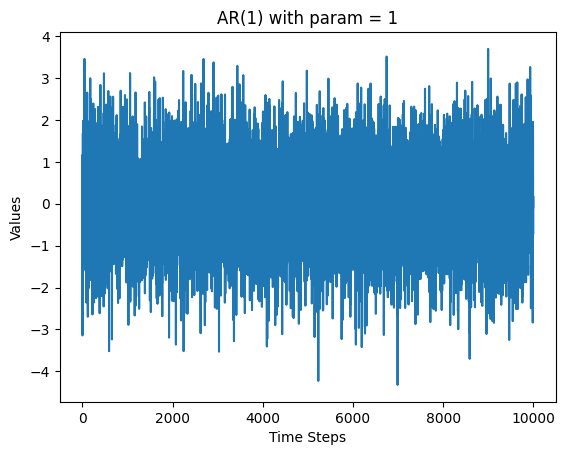

In [277]:
# using the function defined in 'functions' generate a simple AR(1) path
non_stationary_ar_1 = ar(0,[0.2],10000,1,0)
plt.plot(non_stationary_ar_1)
plt.title('AR(1) with param = 1')
plt.xlabel('Time Steps')
plt.ylabel('Values')

In [278]:
adf_test(stationary_momentum_ar_1)

ADF Statistic:  -32.76777895101567
P-Value:  0.0
Critical Value: 
	1%: -3.43
	5%: -2.86
	10%: -2.57


With a lower $\phi$ the momentum is even lower and values converge towards the standard normal error, therefore the distribution is going to be stationary.

#### Monte Carlo of AR(1)
Monte Carlo Simulations allows for a more robust understanding of the patterns that are being explored. When $\phi$ = 1 we are looking at different random walks, using different paths it can become more clear why AR(1) is similar to replicating log prices of stocks. This is a very similar exploration to a binomial random walk or sampling from a normal distribution but the key concept is that the only value that is going to dictate future movement is the most recent value, also known as a Martingale.

##### AR(1) $\phi$ = 1

Mean: 0.947
Std: 31.8212
Skew: 0.0428
Kurtosis: -0.0657


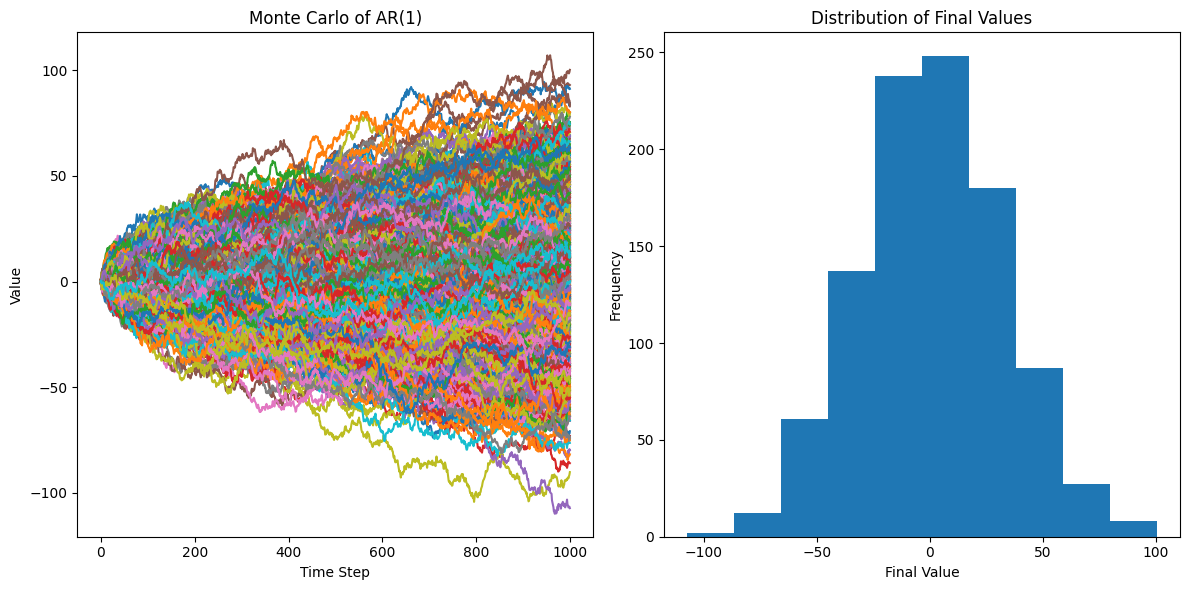

In [280]:
n_simulations = 1000 # get the number of simulations
n_steps = 1000
param_1_ar_1 = [] # store the simulation runs in a list
for i in range(n_simulations): # go through each replication using the function 'ar'
    param_1_ar_1_output = ar(0,[1],1000,1,0)
    param_1_ar_1.append(param_1_ar_1_output)
ar_1_final_values = monte_carlo_output_analysis(n_simulations,param_1_ar_1)

In [281]:
# number of values 
sqrt_n = np.sqrt(n_steps)
for i in range(3):
    clt_check = np.abs(ar_1_final_values) <= (i+1)*sqrt_n
    clt_ratio = round((clt_check.sum()/len(ar_1_final_values)) * 100,2)
    
    print(f'Pct of values inside {i+1} std {clt_ratio}')
print(f'Std of {np.round(np.std(ar_1_final_values),2)}')

Pct of values inside 1 std 68.1
Pct of values inside 2 std 95.6
Pct of values inside 3 std 99.8
Std of 31.82


Central Limit Theorem, Variance Scaling, and the 3-Sigma Rule

By the Central Limit Theorem, the sum of a large number of independent, identically distributed random variables with finite variance converges in distribution to a normal random variable as the number of observations increases.

If each increment has variance $\sigma^2$, then after $n$ time steps the variance of the sum grows linearly as $n\sigma^2$, and the corresponding standard deviation scales as $\sqrt{n}\sigma$.

For sufficiently large $n$ (e.g., $n = 100$), the distribution of the process is well-approximated by a normal distribution. For a normal random variable, approximately 99.7% of observations lie within three standard deviations of the mean.

##### AR(1) $\phi$ = 0.8

Mean: 0.0357
Std: 1.6874
Skew: 0.0497
Kurtosis: -0.0521


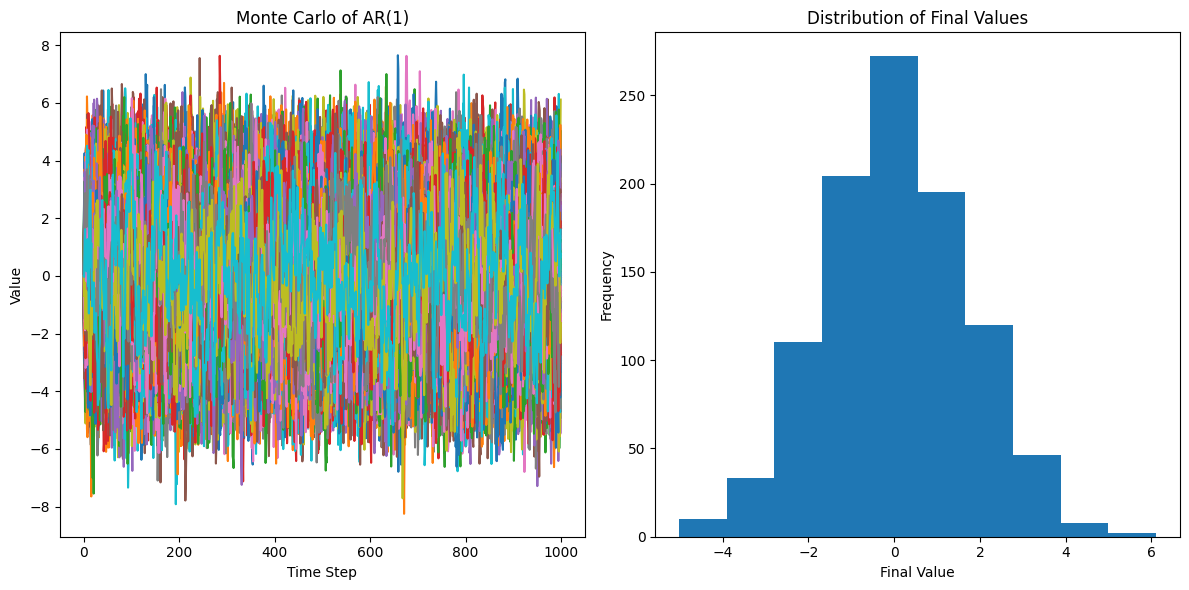

In [282]:
param_08_ar_1 = [] # store the simulation runs in a list
for i in range(n_simulations): # go through each replication using the function 'ar'
    param_08_ar_1_output = ar(0,[0.8],1000,1,0)
    param_08_ar_1.append(param_08_ar_1_output)
ar_1_param_08_final_values = monte_carlo_output_analysis(n_simulations,param_08_ar_1)

Notice the difference in the standard deviation of the Monte Carlo of AR(1) where $\phi$ = 0.8, as there is a mean reverting strategy the furthest values move away from 0 is far lower than the above random walk. Clearly when data is stationary it can be easier to generate trading methodologies as assumptions of reversion to the mean can be made when observing price series. For example if the price is far lower today then it is assumed that next day it is more likely to be closer to the mean.

#### Trading on AR(1)
The following section is going to showcase what happens when one tries to perform a mean reverting strategy on non stationary random walks which is assumed to represent log prices how stocks perform.

##### Trading AR(1) $\phi$ = 0.8
We are now at the point of where we need to start making a reproducable collection of .py's to generate, analyze and perform backtesting strategies.

Text(0, 0.5, 'Random Walk Value')

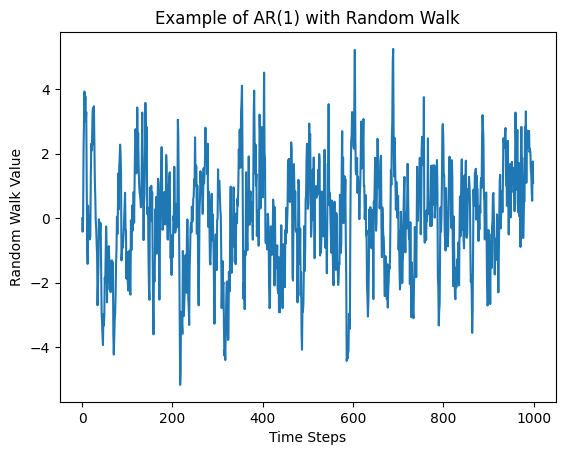

In [190]:
# pull in the old data
test = param_08_ar_1[3]
plt.plot(test)
plt.title('Example of AR(1) with Random Walk')
plt.xlabel('Time Steps')
plt.ylabel('Random Walk Value')

In [191]:
pd.Series(test).to_csv('trading_program/price_data/ar_1_08_test_data.csv')

Mean is 0.0749
Std is 1.634


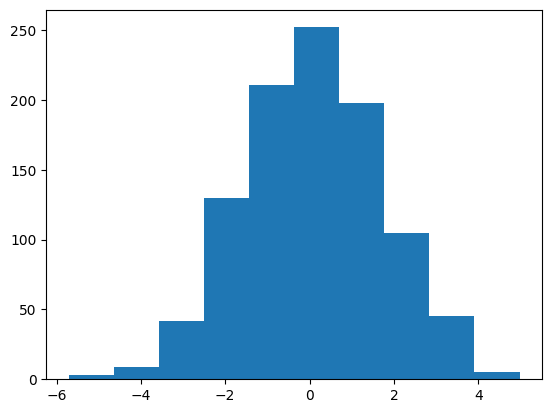

In [192]:
# assume that we are modeling the same underlying princuple and the different AR(1) have been made to make the distribution of returns
plt.hist(ar_1_param_08_final_values)
ar_1_param_08_mean = round(np.mean(ar_1_param_08_final_values),4)
ar_1_param_08_std = round(np.std(ar_1_param_08_final_values),4)
print(f'Mean is {ar_1_param_08_mean}')
print(f'Std is {ar_1_param_08_std}')

In [193]:
# whenever the price is 2std's below the mean
test_decisions = np.where(
    test < -2 * ar_1_param_08_std, "Buy",
    np.where(test > 2 * ar_1_param_08_std, "Sell", "Hold")
)

pd.Series(test_decisions).value_counts()

Hold    944
Buy      33
Sell     23
Name: count, dtype: int64

In [194]:
pd.Series(test_decisions).to_csv('trading_program/signal_data/ar_1_08_test_signals.csv')

This is exactly when I want to be able to access the .py and allow this trading strategy to take place without having to write it out. This is the entire intention of this quant trading initiative is that I am building up different trading techniques and then I use a .py file to easily implement the trading strategy buy/hold/sell directions with associated prices to get metrics such as PnL, max drawdowns etc.

### AR(P)
Uses the last p periods to predict the current one.